<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "CT-L6"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/CT-L6/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


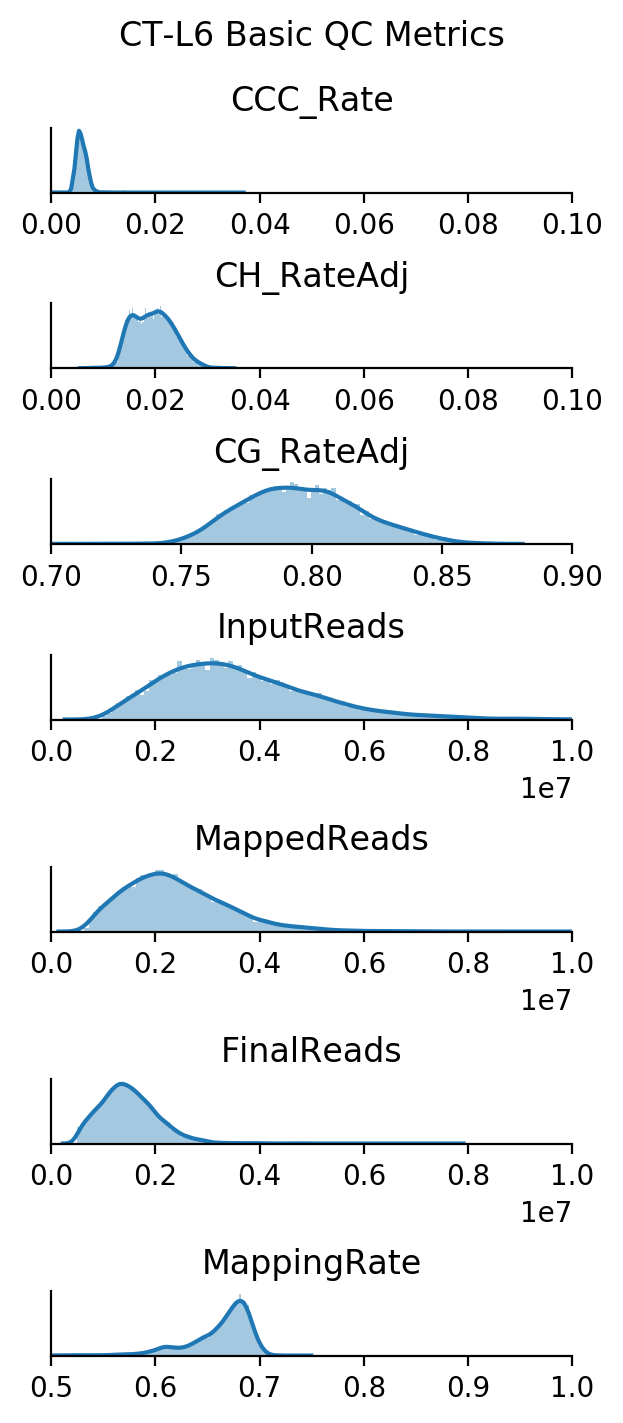

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

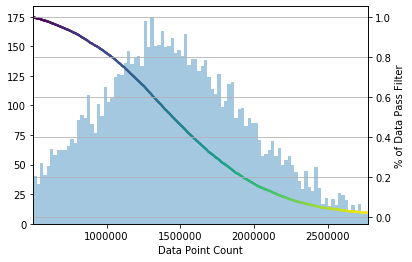

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 8716/8716 (100.0%)
CG_RateAdj passed 8716/8716 (100.0%)
CH_RateAdj passed 8716/8716 (100.0%)
FinalReads passed 8716/8716 (100.0%)
MappingRate passed 8716/8716 (100.0%)
Overall passed 8716/8716 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 205
171207 244
171212 45
171213 242
171214 24
171219 10
180104 257
180109 15
180119 75
180122 175
180123 238
180129 283
180130 255
180205 223
180206 235
180213 50
180220 43
180222 26
180226 8
180227 5
180305 180
180306 275
180312 267
180313 2
180320 16
180326 15
180329 5
180402 5
180403 7
180405 7
180409 33
180410 34
180412 192
180416 197
180417 144
180419 128
180423 236
180424 168
180426 214
180430 186
180501 230
180514 142
180529 196
180605 295
180612 277
180911 4
180917 32
180925 8
181002 236
181009 13
181022 249
181023 247
181204 28
181206 7
181210 208
181218 3
181220 1
190108 271
190117 270
190122 222
190124 208
190131 39
190205 231
190214 36
190305 26
190307 264
190625 1
190627 3


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 1099 286.2%
ad002 1101 286.7%
ad004 1081 281.5%
ad006 1091 284.1%
ad007 1090 283.9%
ad008 1078 280.7%
ad010 1082 281.8%
ad012 1094 284.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1507,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006342,0.802387,0.801126,0.031122,0.024939,1991029.0,5483024,3528895.0,10E,...,14.969936,-21.719334,35.537863,16.022343,CT-L6,24.717123,11.881371,-24.749526,-45.465047,True
10E_M_2605,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007565,0.790334,0.788736,0.036012,0.028664,1626185.0,4874342,3229733.0,10E,...,16.812416,-21.826475,42.062604,15.824434,CT-L6,26.153017,9.666599,-19.928549,-29.490850,True
10E_M_2759,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007780,0.828407,0.827062,0.038774,0.031237,2529542.0,8257394,5385516.0,10E,...,12.581416,-21.927538,31.249539,22.288753,CT-L6,24.047564,12.969217,-21.130021,-48.030664,True
10E_M_694,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006101,0.780607,0.779260,0.025570,0.019588,2216281.0,6526542,4304849.0,10E,...,17.098124,-21.673878,41.975136,15.380674,CT-L6,26.107874,9.523762,-19.455096,-29.684062,True
11E_M_1011,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006768,0.844540,0.843481,0.032750,0.026159,500826.0,1623714,903922.0,11E,...,13.292900,-18.806122,27.904016,5.307080,CT-L6,22.865509,6.838414,-33.255391,-9.398740,True
11E_M_1091,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005644,0.787571,0.786365,0.025709,0.020179,2545031.0,7099976,4880747.0,11E,...,16.942217,-21.412237,40.415597,14.382255,CT-L6,25.971258,9.482279,-19.088914,-29.991846,True
11E_M_1182,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006431,0.783518,0.782117,0.026474,0.020173,1167206.0,2795196,1801150.0,11E,...,17.092657,-20.411249,41.753184,9.864988,CT-L6,26.102798,9.405792,-19.436773,-29.588316,True
11E_M_1307,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005647,0.771611,0.770314,0.024642,0.019103,1393700.0,3288896,2297582.0,11E,...,17.106659,-21.648270,41.988775,15.703339,CT-L6,26.406076,8.871085,-14.437269,-24.197266,True
11E_M_1345,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006081,0.790586,0.789305,0.028852,0.022911,1224559.0,2702726,1851280.0,11E,...,17.218336,-21.683983,42.609090,15.681619,CT-L6,26.395538,8.820867,-15.053739,-23.803605,True
